In [60]:
# Created during May 25 HACKATHON by JD

# Calculates win percentage given on game score for both players.

In [61]:
from copy import deepcopy
import csv
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

log_files = [
    '/home/cesar/data/autogenerated-data/20220823/autogenerate_20220823_autoplay_5.csv',   # a CSW21 set
    '/home/cesar/data/autogenerated-data/20220824/autogenerate_20220825_autoplay_3.csv']   # a NWL20 set

todays_date = date.today().strftime("%Y%m%d")
pd.options.display.max_rows = 999


In [65]:
spread = {}
win_dict = {}

t0 = time.time()

# because moves are logged chronologically, we can overwrite the entry for each game ID
# for each move until we reach the final move, at which point we know the final state of the game.
for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)

        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            if i<10:
                print(row)

            # This flag indicates whether p1 won or not, with 0.5 as the value if the game was tied.
            if row[0]=='p1':
                spread[row[1]] = int(row[6])-int(row[11])
            else:
                spread[row[1]] = int(row[11])-int(row[6])
            

['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
['p2', '6305d312010f678f3a000001', '2', 'ACHINOZ', ' F4 HOAC.ZIN', '76', '76', '7', '', '76.000', '80', '30']
['p2', '6305d312010f678f

Processed 27000000 rows in 105.20262885093689 seconds
Processed 28000000 rows in 106.12865972518921 seconds
Processed 29000000 rows in 107.05152606964111 seconds
Processed 30000000 rows in 107.96965551376343 seconds
Processed 31000000 rows in 108.88993549346924 seconds
Processed 32000000 rows in 109.80251216888428 seconds
Processed 33000000 rows in 110.7172794342041 seconds
Processed 34000000 rows in 111.63112998008728 seconds
Processed 35000000 rows in 112.54950070381165 seconds
Processed 36000000 rows in 113.46948790550232 seconds
Processed 37000000 rows in 114.51725029945374 seconds
Processed 38000000 rows in 115.42868900299072 seconds
Processed 39000000 rows in 116.34473204612732 seconds
Processed 40000000 rows in 117.25287818908691 seconds
Processed 41000000 rows in 118.1550714969635 seconds
Processed 42000000 rows in 119.06197595596313 seconds
Processed 43000000 rows in 119.97382068634033 seconds
Processed 44000000 rows in 120.88642406463623 seconds
Processed 45000000 rows in 121

Can define what spread beyond which you assume player has a 0 or 100% chance of winning - using 300 as first guess.

Also, spreads now range only from 0 to positive numbers, because trailing by 50 and winning is the same outcome and leading by 50 and losing (just swapping the players' perspectives)

In [66]:
for game_id in spread.keys():
    win_dict[game_id] = (np.sign(spread[game_id])+1)/2
    
# win_dict is always from the perspective of p1

In [67]:
max_spread = 300
counter_dict_by_spread_and_tiles_remaining = {x:{
    spread:0 for spread in range(max_spread,-max_spread-1,-1)} for x in range(0,94)}
win_counter_dict_by_spread_and_tiles_remaining = deepcopy(counter_dict_by_spread_and_tiles_remaining)


t0=time.time()
MAX_RACK_TILES = 7
print('There are {} games'.format(len(win_dict)))
last_evt = {}

for log_file in log_files:
    with open(log_file,'r') as f:
        moveReader = csv.reader(f)
        next(moveReader)

        for i,row in enumerate(moveReader):
            if (i+1)%1000000==0:
                print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

            # truncate spread to the range -max_spread to max_spread
            # tiles in bag at the beginning of turn, minus tiles used, plus tiles in opponent's rack.
            if row[1] in last_evt:
                last_row = last_evt[row[1]]
                if int(last_row[10]) < 7:
                    # The bag is almost empty. The opponent has their last leave in their rack + the number of tiles
                    # in the bag. See this sequence of moves to understand.
                    # playerID,gameID,turn,rack,play,score,totalscore,tilesplayed,leave,equity,tilesremaining,oppscore
                    # p2,6305d312010f678f3a000001,16,AEEEFSV, H1 FAVES.,39,342,5,EE,38.555,10,337
                    # p1,6305d312010f678f3a000001,17,GHMOQST,L11 MO.TH,28,365,4,GQS,17.622,5,342
                    # p2,6305d312010f678f3a000001,18,AEEILOU,K10 EUO.,22,364,3,AEIL,28.010,1,365
                    # p1,6305d312010f678f3a000001,19,AEGGIQS, M9 QIS,28,393,3,AEGG,6.000,0,364
                    # p2,6305d312010f678f3a000001,20,AEILN,15J IN.ALE,27,403,5,,39.000,0,393
                    # p2 played FAVES. keeping EE, and there were 10 tiles in the bag. So they draw 5 of them to
                    # make 7 again.
                    # p1 played MO.TH keeping GQS, and there were 5 tiles in the bag. So they draw 4 of them to
                    # make 7 again. 
                    # p2 played EUO. keeping AEIL, and there was 1 tile in the bag. They draw the last tile, and
                    # now have 5 in their rack.
                    # p1 played QIS keeping AEGG. There are no more tiles to draw, so they have 4 in their rack.
                    # p2 went out with IN.ALE.
                    num_tiles_in_opp_rack = min(len(last_row[8]) + int(last_row[10]), MAX_RACK_TILES)
            else:
                num_tiles_in_opp_rack = MAX_RACK_TILES
            # end_of_turn means "after replenishing my rack"
            # example of an exchange:
            # p2,6305d5d1010f678f3a064aef,17,EGOSUUU,(exch GOUUU),0,277,2,ES,11.954,14,322
            tilesplayed = int(row[7])
            if row[4].startswith('(exch'):
                # XXX: this is because of bug in the move logger. DELETE THIS WHEN WE CREATE A NEW GAME LOG.
                # XXX XXX XXX XXX
                tilesplayed = MAX_RACK_TILES - tilesplayed
            
            end_of_turn_tiles_unseen = max(int(row[10])-tilesplayed + num_tiles_in_opp_rack, 0)
            
            end_of_turn_spread = min(max(int(row[6])-int(row[11]),-max_spread),max_spread)

            if end_of_turn_tiles_unseen > 0:
                counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_unseen][end_of_turn_spread] += 1
#                 counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_unseen][-end_of_turn_spread] += 1

                # At the end of this turn, it is the other player's turn. So if this turn was taken
                # by p1, it is actually p2's turn and it is p2 for whom we want to compute the win%
                # XXX
                if row[0]=='p1':
                    win_counter_dict_by_spread_and_tiles_remaining[
                        end_of_turn_tiles_unseen][end_of_turn_spread] += (win_dict[row[1]])
#                     win_counter_dict_by_spread_and_tiles_remaining[
#                         end_of_turn_tiles_unseen][-end_of_turn_spread] += 1-win_dict[row[1]]
                else:
                    win_counter_dict_by_spread_and_tiles_remaining[
                        end_of_turn_tiles_unseen][end_of_turn_spread] += 1-win_dict[row[1]]
#                     win_counter_dict_by_spread_and_tiles_remaining[
#                         end_of_turn_tiles_unseen][-end_of_turn_spread] += win_dict[row[1]]

            last_evt[row[1]] = row
                    
            # debug rows
            if i<10:
                print(row)
                print(end_of_turn_spread)
                print(end_of_turn_tiles_unseen)
                print(counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_unseen][end_of_turn_spread])
                print(win_counter_dict_by_spread_and_tiles_remaining[end_of_turn_tiles_unseen][end_of_turn_spread])

There are 8000000 games
['p1', '6305d312010f678f3a000001', '1', 'AAAEKOT', ' 8C AKATEA', '30', '30', '6', 'O', '27.504', '86', '0']
30
87
1
0.0
['p1', '6305d312010f678f3a000002', '1', 'CEHNOOT', ' 8C THEOCON', '82', '82', '7', '', '82.000', '86', '0']
82
86
1
1.0
['p2', '6305d312010f678f3a000005', '1', 'EEEIMSU', ' 8H EMEU', '12', '12', '4', 'EIS', '25.680', '86', '0']
12
89
1
1.0
['p2', '6305d312010f678f3a000006', '1', 'EFOORRT', ' 8D FOOTER', '26', '26', '6', 'R', '27.928', '86', '0']
26
87
1
0.0
['p2', '6305d312010f678f3a000002', '2', 'CDLLOTY', ' E4 CLOY.D', '24', '24', '5', 'LT', '22.888', '79', '82']
-58
81
1
0.0
['p2', '6305d312010f678f3a000007', '1', 'EINNRRT', ' 8D TINNER', '14', '14', '6', 'R', '15.928', '86', '0']
14
87
1
0.0
['p1', '6305d312010f678f3a000003', '1', 'CGINOPS', ' 8D COPSING', '80', '80', '7', '', '80.000', '86', '0']
80
86
1
1.0
['p1', '6305d312010f678f3a000004', '1', 'ADENORR', ' 8C ADORNER', '70', '70', '7', '', '69.300', '86', '0']
70
86
1
0.0
['p2', '6305d

Processed 20000000 rows in 207.52484107017517 seconds
Processed 21000000 rows in 209.36589741706848 seconds
Processed 22000000 rows in 211.21755123138428 seconds
Processed 23000000 rows in 213.0717589855194 seconds
Processed 24000000 rows in 214.92701625823975 seconds
Processed 25000000 rows in 216.77706360816956 seconds
Processed 26000000 rows in 218.63631558418274 seconds
Processed 27000000 rows in 220.4939124584198 seconds
Processed 28000000 rows in 222.35039377212524 seconds
Processed 29000000 rows in 224.205335855484 seconds
Processed 30000000 rows in 226.06577515602112 seconds
Processed 31000000 rows in 227.92396187782288 seconds
Processed 32000000 rows in 231.95778489112854 seconds
Processed 33000000 rows in 233.8170702457428 seconds
Processed 34000000 rows in 235.6854863166809 seconds
Processed 35000000 rows in 237.5444622039795 seconds
Processed 36000000 rows in 239.39781999588013 seconds
Processed 37000000 rows in 241.36607766151428 seconds
Processed 38000000 rows in 243.2022

In [68]:
count_df = pd.DataFrame(counter_dict_by_spread_and_tiles_remaining)
win_df = pd.DataFrame(win_counter_dict_by_spread_and_tiles_remaining)
win_pct_df = (win_df/count_df)

def mapfn(p):
    if p == 0:
        p = 0.0001
    if p == 1:
        p = 0.9999
    return np.log(p/(1-p))

# "stretch out" the distribution by applying a logit transformation
logit_df = win_pct_df.applymap(mapfn)

In [69]:
win_counter_dict_by_spread_and_tiles_remaining

{0: {300: 0,
  299: 0,
  298: 0,
  297: 0,
  296: 0,
  295: 0,
  294: 0,
  293: 0,
  292: 0,
  291: 0,
  290: 0,
  289: 0,
  288: 0,
  287: 0,
  286: 0,
  285: 0,
  284: 0,
  283: 0,
  282: 0,
  281: 0,
  280: 0,
  279: 0,
  278: 0,
  277: 0,
  276: 0,
  275: 0,
  274: 0,
  273: 0,
  272: 0,
  271: 0,
  270: 0,
  269: 0,
  268: 0,
  267: 0,
  266: 0,
  265: 0,
  264: 0,
  263: 0,
  262: 0,
  261: 0,
  260: 0,
  259: 0,
  258: 0,
  257: 0,
  256: 0,
  255: 0,
  254: 0,
  253: 0,
  252: 0,
  251: 0,
  250: 0,
  249: 0,
  248: 0,
  247: 0,
  246: 0,
  245: 0,
  244: 0,
  243: 0,
  242: 0,
  241: 0,
  240: 0,
  239: 0,
  238: 0,
  237: 0,
  236: 0,
  235: 0,
  234: 0,
  233: 0,
  232: 0,
  231: 0,
  230: 0,
  229: 0,
  228: 0,
  227: 0,
  226: 0,
  225: 0,
  224: 0,
  223: 0,
  222: 0,
  221: 0,
  220: 0,
  219: 0,
  218: 0,
  217: 0,
  216: 0,
  215: 0,
  214: 0,
  213: 0,
  212: 0,
  211: 0,
  210: 0,
  209: 0,
  208: 0,
  207: 0,
  206: 0,
  205: 0,
  204: 0,
  203: 0,
  202: 0,
  201: 

Text(0.5, 1.0, 'log-odds by tiles remaining and spread')

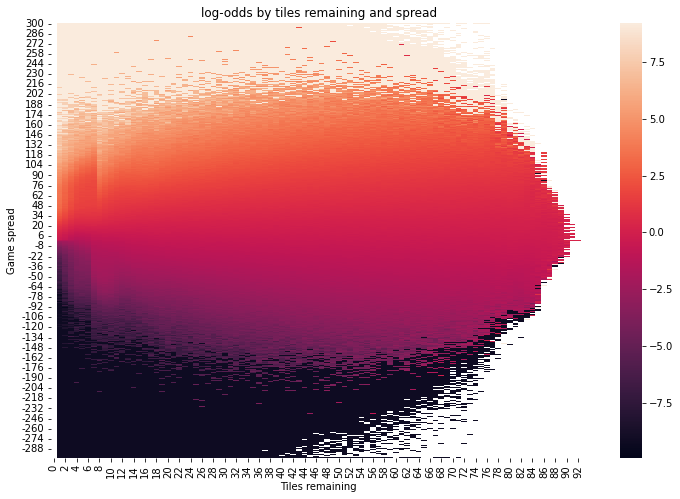

In [78]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(logit_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('log-odds by tiles remaining and spread')

Text(0.5, 1.0, 'unsmoothed win pct by tiles remaining and spread')

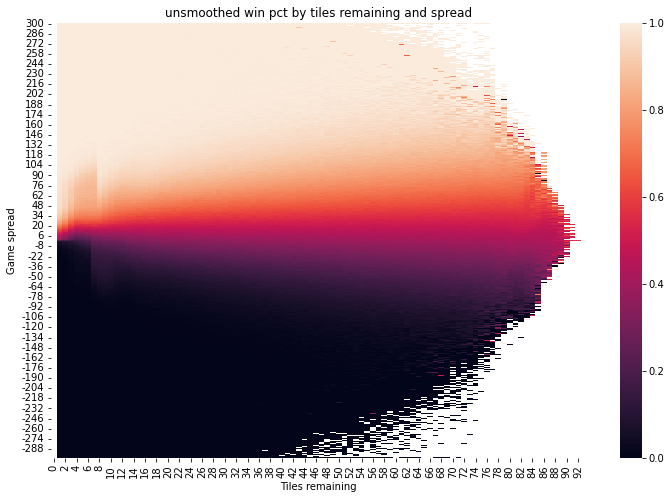

In [77]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(win_pct_df, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('unsmoothed win pct by tiles remaining and spread')

In [71]:
logit_df[1][100]  # tiles remaining, 100 game spread:

5.571891771489127

#### Remove outliers by assigning to each "pixel" the average of itself and its eight neighbors, removing the highest and lowest value

In [72]:
import math
averaged_copy = logit_df.copy()

def average_around(df, i1, i2):
    s = 0
    ct = 0
    vals = []
    for x in (i1-1, i1, i1+1):
        for y in (i2-1, i2, i2+1):
#             if x == i1 and y == i2:
#                 pass
            try:
                if np.isnan(df[x][y]):
                    continue
                vals.append(df[x][y])
                s += df[x][y]
                ct += 1
            except KeyError:
                continue
    if ct > 2:  # Remove outliers from averaging.
        s -= max(vals)
        s -= min(vals)
        
        ct -= 2
    if ct == 0: return math.nan
    return s / ct


for row in logit_df.itertuples():  # one row for each spread
    spread = row.Index
    last_known_val = -100
    for idx, w in enumerate(row[1:]):  # idx here is tiles remaining
        avg = average_around(logit_df, idx, row.Index)
        if np.isnan(avg):
            if last_known_val != -100:
                averaged_copy[idx][row.Index] = last_known_val
        else:
            last_known_val = avg
            averaged_copy[idx][row.Index] = avg
        
        

Text(0.5, 1.0, 'averaged log-odds by tiles remaining and spread')

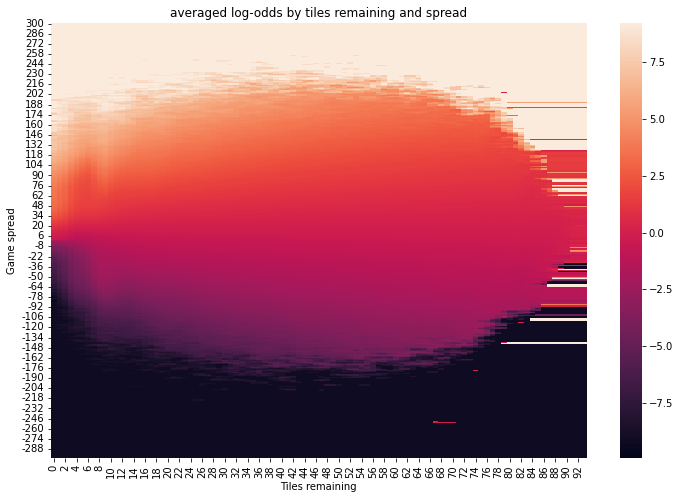

In [73]:
fig,ax = plt.subplots(figsize=(12,8))
sns.heatmap(averaged_copy, ax=ax)
ax.set_xlabel('Tiles remaining')
ax.set_ylabel('Game spread')
ax.set_title('averaged log-odds by tiles remaining and spread')

In [74]:
def logisticfn(p):
    return np.exp(p) / (np.exp(p) + 1)

# convert back to win probability.
smoothed_winpct_df = averaged_copy.applymap(logisticfn)

Text(0.5, 1.0, 'Unsmoothed win pct by tiles remaining and spread')

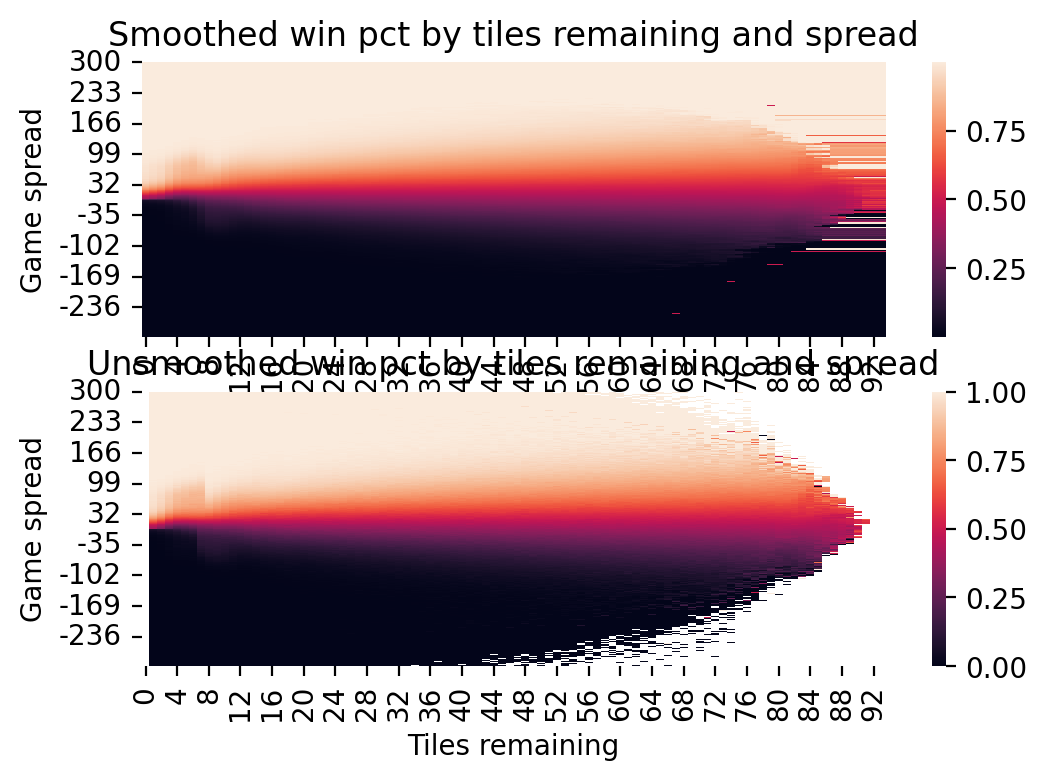

In [75]:
fig, (ax1, ax2) = plt.subplots(2,1)
fig.set_dpi(200)
sns.heatmap(smoothed_winpct_df, ax=ax1)
ax1.set_ylabel('Game spread')
ax1.set_title('Smoothed win pct by tiles remaining and spread')

sns.heatmap(win_pct_df, ax=ax2)
ax2.set_xlabel('Tiles remaining')
ax2.set_ylabel('Game spread')
ax2.set_title('Unsmoothed win pct by tiles remaining and spread')

In [76]:
# Fill in missing data.

# Export smoothed win pct 
smoothed_winpct_df.to_csv('smoothed_winpct.csv', float_format='%.6f')

## Everything below this cell seems experimental

In [ ]:
plt.savefig('win_pct.jpg')

In [ ]:
count_df.iloc[300:350,79:]

The 50% win line is likely a little bit above 0 spread, because when you end a turn with 0 spread, your opponent on average gets an extra half-turn more than you for the rest of the game. Let's find that line.

In [ ]:
win_pct_df.iloc[250:350,79:]

## Opening turn scores

In [ ]:
pd.options.display.max_rows = 999

## Apply smoothing
We want the win percentage to increase monotonically with spread, even though we have a limited sample size and this may not always be true. Therefore, we want to be able to average win percentages over neighboring scenarios (similar spread difference and similar # of tiles remaining).

In [ ]:
counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
win_counter_dict_by_opening_turn_score = {x:0 for x in range(0,131)}
rows = []

In [ ]:
t0=time.time()
print('There are {} games'.format(len(win_dict)))

with open(log_file,'r') as f:
    moveReader = csv.reader(f)
    next(moveReader)
    
    for i,row in enumerate(moveReader):
        if (i+1)%1000000==0:
            print('Processed {} rows in {} seconds'.format(i+1, time.time()-t0))

        if row[2]=='1':
            counter_dict_by_opening_turn_score[int(row[5])] += 1
            
            # check which player went first
            if row[0]=='p1':
                win_counter_dict_by_opening_turn_score[int(row[5])] += win_dict[row[1]]
                rows.append([int(row[5]), win_dict[row[1]]])
            else:
                win_counter_dict_by_opening_turn_score[int(row[5])] += 1-win_dict[row[1]]
                rows.append([int(row[5]), 1-win_dict[row[1]]])

        
#         # debug rows
#         if i<10:
#             print(row)

In [ ]:
tst_df=pd.DataFrame(rows).rename(columns={0:'opening turn score',1:'win'})

In [ ]:
opening_turn_count = pd.Series(counter_dict_by_opening_turn_score)
opening_turn_win_count = pd.Series(win_counter_dict_by_opening_turn_score)
opening_turn_win_pct = opening_turn_win_count/opening_turn_count

In [ ]:
tst = opening_turn_win_pct.dropna()

In [ ]:
opening_turn_win_pct

In [ ]:
fig,ax=plt.subplots()
plt.plot(tst)
plt.savefig('plot1.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax)
plt.savefig('regression_plot.png')

In [ ]:
fig,ax=plt.subplots()
sns.regplot(x='opening turn score',y='win',data=tst_df,x_estimator=np.mean,ax=ax,fit_reg=False)
plt.savefig('regression_plot_no_fitline.png')